In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from non_parametric_collocation import collocate_data

# pyomo
import importlib
import nn_pyomo

importlib.reload(nn_pyomo)
NeuralODEPyomo = nn_pyomo.NeuralODEPyomo

collocation_path = os.path.abspath(os.path.join('..', 'utils'))

if collocation_path not in sys.path:
    sys.path.append(collocation_path)
    
from interpolation import BarycentricInterpolation

import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d

### Data Generation

In [3]:
def generate_chebyshev_nodes(n, start, end):
    k = np.arange(n)
    x = np.cos(np.pi * k / (n - 1))
    nodes = 0.5 * (end - start) * x + 0.5 * (start + end)
    return np.sort(nodes)

In [4]:
data = pd.read_csv('df_train.csv')

data_subsample = data[data.settlement_date >= '2010-01-00']
data_subsample = data_subsample[data_subsample.settlement_date < '2010-01-10']
data_subsample.reset_index(drop=True, inplace=True)

data_subsample['settlement_date'] = pd.to_datetime(data_subsample['settlement_date'])
data_subsample.loc[:,'hour'] = data_subsample['settlement_date'].dt.hour

# select the main columns for the intial testing
data_subsample = data_subsample[['settlement_date', 'temperature', 'hour', 'nd']]

print(f"The first/ last time points in the subsample are {np.min(data_subsample.settlement_date)}/ {np.max(data_subsample.settlement_date)}")
print(f"Covering {np.max(data_subsample['settlement_date'].dt.day) - np.min(data_subsample['settlement_date'].dt.day)} days")

t = jnp.linspace(0., 1., data_subsample.shape[0]) 

# How many points cover one day?   
one_day_map = (data_subsample['settlement_date'].dt.day == np.min(data_subsample['settlement_date'].dt.day))
n_pt_per_day = one_day_map.sum()
print(f"Number of points per day: {n_pt_per_day}")

one_day_offset = (1/data_subsample.shape[0]) * n_pt_per_day
print(f"Time offset needed for 1 day: {one_day_offset}")

data_subsample.rename(columns={'settlement_date': 'date', 'temperature': 'var1', 'hour':'var2', 'nd':'y'}, inplace=True)
data_subsample['t'] = t

The first/ last time points in the subsample are 2010-01-01 00:00:00/ 2010-01-09 23:30:00
Covering 8 days
Number of points per day: 48
Time offset needed for 1 day: 0.1111111111111111


In [5]:

def preprocessing(data_subsample, tau, m):
    """

    Args:
        data_subsample (dataframe): dataframe containing the subsample of the data;
        expected column names are: 'y', 'date', 'var1', 'var2' ect.
        tau (float): number of points per lag
        m (int): number of lags
    """
    d = data_subsample.copy()   
    columns = data_subsample.columns
    if 't' not in columns:
        raise ValueError("The time column is not present in the dataframe")
    if 'y' not in columns:
        raise ValueError("The target column is not present in the dataframe")
    
    t, y = data_subsample['t'], data_subsample['y']
    
    #----------------------------- SMOOTHING -----------------------------#
    SIGMA = 2
    y = gaussian_filter1d(y, sigma = SIGMA)
    d['y'] = y
    
    #--------------------------------- LAGS -----------------------------#
    for i in range(1, m+1):
        d[f'y_lag{i}'] = d['y'].shift(tau*i)
            
    # the first point that has the last lag available
    first_index = d[f'y_lag{i}'].index[~d[f'y_lag{i}'].isna()][0]

    # drop rows where time lags are not available
    d = d.iloc[first_index:]
    t = d['t'] # reload 't' after slicing 
        
    split = int(0.5 * len(t)) # 50/50 split
    t_train, t_test = t[:split], t[split:]

    print(f"Training data: {t_train.shape[0]} timepoints")
    print(f"Training data: {t_test.shape[0]} timepoints")

    #-------------------- CHEBYSHEV NODES FOR THE TRAIN DATA ---------------------#
    NUM_OF_NODES = 300 
    
    t_train = generate_chebyshev_nodes(NUM_OF_NODES, t_train.min(), t_train.max())
    
    #------------------------- INTERPOLATION FUNCTIONS ---------------------------#

    var_cols_map = ['var' in col for col in d.columns]
    var_cols = d.columns[var_cols_map]
    
    # 1. fit interpolation functions 
    # 2. geneate data
    # 3. save to a new dataframe
    
    interpolated_data_train = {}
    interpolated_data_test = {}
    
    # INDEPENDENT VARIABLES
    for var in var_cols:
        cs = CubicSpline(t, d[var])
        interpolated_data_train[var] = cs(t_train)
        interpolated_data_test[var] = cs(t_test)
        
    # DEPENDENT VARIABLES    
    cs_y = CubicSpline(t, d['y'])
    interpolated_data_train['y'] = cs_y(t_train)
    interpolated_data_test['y'] = cs_y(t_test)
    
    # LAGGED DEPENDENT VARIABLES
    for i in range(1, m+1):
        cs = CubicSpline(t, d[f'y_lag{i}'])
        interpolated_data_train[f'y_lag{i}'] = cs(t_train)
        # here we need some logic to reuse the data available from the training set
        interpolated_data_test[f'y_lag{i}'] = cs(t_test)
        # this gives the whole range, but we need to cut it off where the training data ends
        offset = tau*i # points are needed for the lag
        for p in range(offset, len(t_test)):
            interpolated_data_test[f'y_lag{i}'][p] = np.nan
        
    # TIME
    interpolated_data_train['t'] = t_train
    interpolated_data_test['t'] = t_test

    print(f"Training data: {t_train.shape[0]} timepoints after interpolation")
    
    df_train = pd.DataFrame(interpolated_data_train)
    df_test = pd.DataFrame(interpolated_data_test)

    #------------------------- SCALE ---------------------------#
    scaler = StandardScaler()
    
    columns_to_scale = df_train.columns.difference(['t'])
    df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
    df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])
    
    return df_train, df_test

In [6]:
df_train, df_test = preprocessing(data_subsample, 48, 2)

Training data: 168 timepoints
Training data: 168 timepoints
Training data: 300 timepoints after interpolation


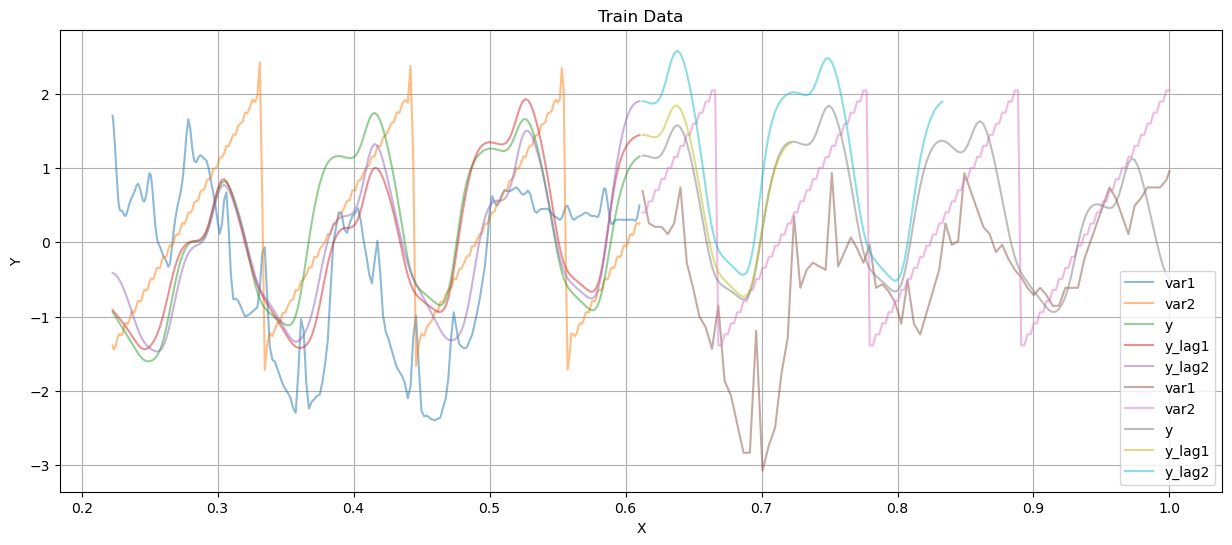

In [7]:
if True:
    plt.figure(figsize=(15, 6))
    for col in df_train.columns.difference(['t']):
        plt.plot(df_train['t'], df_train[col], '-', label=col, alpha=0.5)
        
    for col in df_test.columns.difference(['t']):
        plt.plot(df_test['t'], df_test[col], '-', label=col, alpha=0.5)
    #plt.plot(t_train, y_train_scaled, '-', label='X_train_scaled', alpha=0.5)
    #plt.plot(x_train_cheb_lags, Xs[:,:2], 'b-', label='Dependent Variables', alpha=0.4, ls = '--')

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Train Data')
    plt.grid(True)
    plt.show()

In [8]:
ys = np.atleast_2d(df_train['y']).T
ts = np.array(df_train['t'])
Xs = np.array(df_train.drop(columns=['y', 't']))

In [9]:
weights = compute_weights(ts)
Ds = np.array(lagrange_derivative(ts, weights))

#### Determine the optimal number of delayed inputs

In [26]:
df_train, df_test = preprocessing(data_subsample, 24, 4)
layer_widths = [7, 30, 1]

ys = np.atleast_2d(df_train['y']).T
ts = np.array(df_train['t'])
Xs = np.array(df_train.drop(columns=['y', 't']))

import nn_pyomo
importlib.reload(nn_pyomo)
NeuralODEPyomo = nn_pyomo.NeuralODEPyomo
# ----------------------------------------------------------- #

layer_widths = [7, 30, 1]

# solver.options['print_level'] = 5
tol = 1e-4
params = {"tol":1e-4, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          "acceptable_tol": 1e-15,
          "acceptable_constr_viol_tol": 1e-15,
          "acceptable_dual_inf_tol": 1e-15,
          "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          #'nlp_scaling_method' = 'gradient-based',
          # 'linear_solver'] = 'ma57',
          "max_iter": 1000}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(ys), # y
                           np.array(ts), # t
                           np.array(Ds),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = ys, 
                           penalty_lambda_reg = 0.01, 
                           penalty_lambda_input = 0.0000,
                           # constraint_penalty = 1e-5,  
                           time_invariant = True,
                           extra_input = Xs, # X
                           w_init_method = 'xavier', 
                           params = params,
                           constraint="l1",
                           deriv_method="pyomo"
                           )

ode_model.build_model()
end_timer_build = time.time()
result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

Training data: 168 timepoints
Training data: 168 timepoints
Training data: 300 timepoints after interpolation
Ipopt 3.14.16: tol=0.0001
dual_inf_tol=0.0001
compl_inf_tol=0.0001
constr_viol_tol=0.0001
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   249366
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagran

Mean Absolute Error - Direct: 0.18839127051840118
Mean Absolute Error - ODE solver: 0.39167703061089243


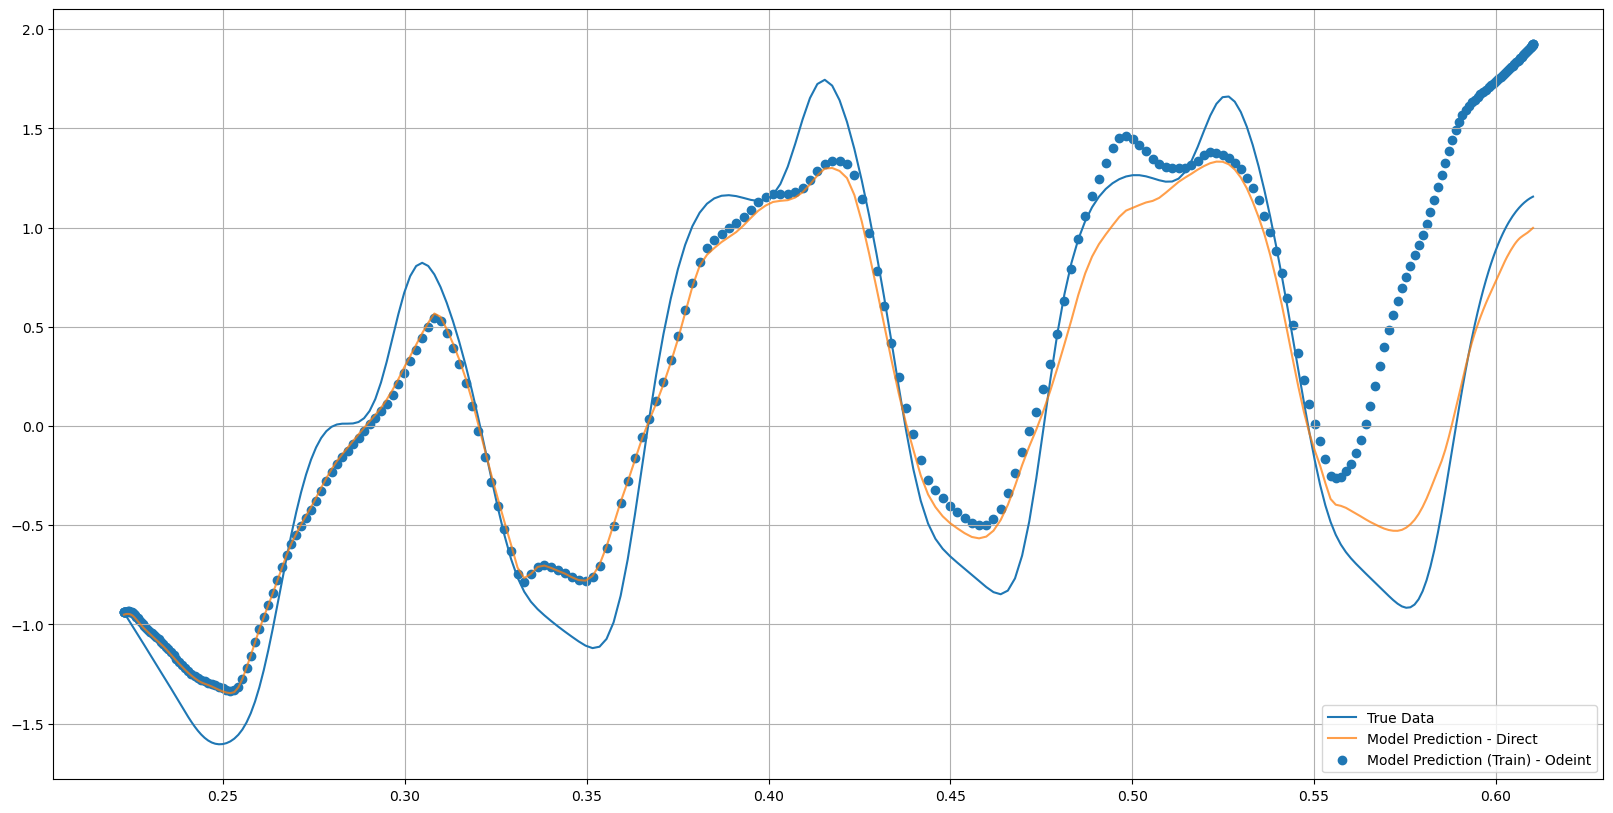

In [27]:
#importlib.reload(neural_net_pyomo_2)
#NeuralODEPyomo = neural_net_pyomo_2.NeuralODEPyomo

y0 = ys[0]
# step_1 = 150
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")

#y0_test = y_test_scaled[0]
#y_pred_test = ode_model.neural_ode(y0_test, ts_test, (Xs_test, ts_test))

plt.figure(figsize=(20, 10))
# plt.plot(ts, y_train_scaled[offset : train_end], label='True Data', alpha = 0.5)
plt.plot(ts, ys, label='True Data', alpha = 1)
# plt.plot(ts, Xs, label='True Data', alpha = 1)
# plt.plot(t_test, y_test_scaled, '--', alpha = 0.3)
# plt.plot(t_test[0], y_test_scaled[0], 'o', alpha = 1)

# ---------------------------------- EXTRA INPUT ---------------------------------- #
# plt.plot(ts, extra_input, label='Independent Variables', alpha = 0.3, ls = '--')
# plt.plot(t_test, np.array(X_test_scaled), alpha = 0.3, ls = '--')

plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')

# plt.scatter(ts_test, y_pred_test, label='Model Prediction (Test) - Odeint')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [ ]:
collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from data_generation import generate_ode_data

#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type = "harmonic_oscillator"
params = {"omega_squared": 2}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)
y_noisy = jnp.squeeze(y_noisy)
#---------------------------------------COLLOCATION MATRIX--------------------------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)

estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

ys = y_noisy
ts = t
Ds = D
Xs = None

In [ ]:
layer_widths = [2, 20, 2]

# solver.options['print_level'] = 5
tol = 1e-3
params = {"tol":1e-3, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          "acceptable_tol": 1e-15,
          "acceptable_constr_viol_tol": 1e-15,
          "acceptable_dual_inf_tol": 1e-15,
          "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          "max_iter": 3000}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(ys), # y
                           np.array(ts), # t
                           np.array(Ds),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = estimated_solution.T, 
                           penalty_lambda_reg = 0.001, 
                           penalty_lambda_input = 0.0000,
                           # constraint_penalty = 1e-5,  
                           time_invariant = True,
                           extra_input = Xs, # X
                           w_init_method = 'xavier', 
                           params = params
                           # constraint="l1"
                           )

ode_model.build_model()
end_timer_build = time.time()
result = ode_model.solve_model()
u_model = ode_model.extract_solution().T